In [1]:
#Library Imports
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.USPS(root='usps', download=True, transform=ToTensor(), train=True)
test_data = datasets.USPS(root='usps', download=True, transform=ToTensor(), train=False)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [3]:
# Define the MLP model with 1 hidden layer of width 65, following the specified structure
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(16 * 16, 64),  # Input layer to hidden layer
            nn.ReLU(),
            nn.Linear(64, 64),       # Hidden layer
            nn.ReLU(),
            nn.Linear(64, 10)        # Output layer
        )

    def forward(self, X):
        return self.mlp(self.flatten(X))


model = MLP().to('cuda:1')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [4]:
%%time
epochs = 1000
training_accuracy = []
test_accuracy = []
epoch_loss = []

for epoch in range(epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    for X, Y in train_loader:
        X, Y = X.to('cuda:1'), Y.to('cuda:1')
        out = model(X)
        loss = loss_fn(out, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
        cumulative_accuracy += (out.argmax(axis=1) == Y).sum().item()

    epoch_loss.append(cumulative_loss / len(train_loader))
    training_accuracy.append(cumulative_accuracy / len(train_data))

    with torch.no_grad():
        for Xt, Yt in test_loader:
            Xt, Yt = Xt.to('cuda:1'), Yt.to('cuda:1')
            test_out = model(Xt)
            test_accuracy_epoch = (test_out.argmax(axis=1) == Yt).sum().item() / len(test_data)
        test_accuracy.append(test_accuracy_epoch)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Loss: {epoch_loss[-1]:.4f} | Training Accuracy: {training_accuracy[-1]:.4f} | Test Accuracy: {test_accuracy[-1]:.4f}")

Epoch 100/1000 | Loss: 0.0351 | Training Accuracy: 0.9900 | Test Accuracy: 0.9352
Epoch 200/1000 | Loss: 0.8745 | Training Accuracy: 0.7106 | Test Accuracy: 0.7937
Epoch 300/1000 | Loss: 0.0164 | Training Accuracy: 0.9971 | Test Accuracy: 0.9387
Epoch 400/1000 | Loss: 0.0073 | Training Accuracy: 0.9993 | Test Accuracy: 0.9337
Epoch 500/1000 | Loss: 1.8209 | Training Accuracy: 0.3395 | Test Accuracy: 0.4190
Epoch 600/1000 | Loss: 0.2941 | Training Accuracy: 0.9093 | Test Accuracy: 0.8321
Epoch 700/1000 | Loss: 0.5172 | Training Accuracy: 0.8287 | Test Accuracy: 0.7833
Epoch 800/1000 | Loss: 0.1645 | Training Accuracy: 0.9468 | Test Accuracy: 0.8999
Epoch 900/1000 | Loss: 1.5180 | Training Accuracy: 0.3973 | Test Accuracy: 0.3234
Epoch 1000/1000 | Loss: 0.5628 | Training Accuracy: 0.8098 | Test Accuracy: 0.7434
CPU times: user 10min 37s, sys: 844 ms, total: 10min 38s
Wall time: 10min 38s


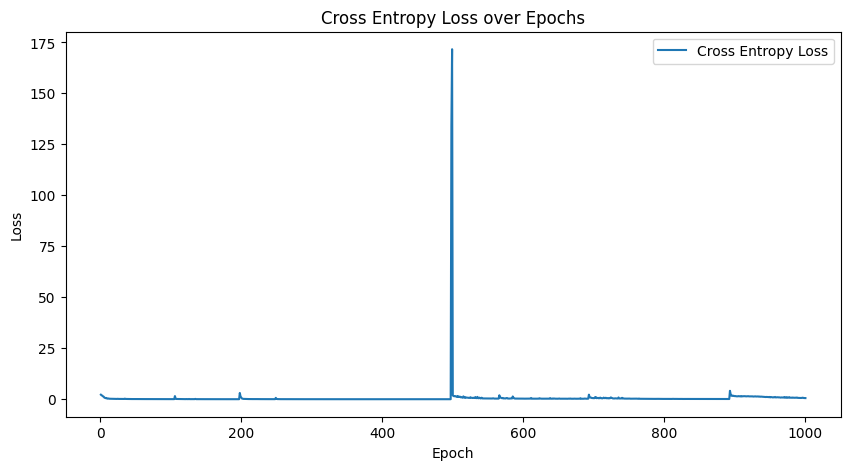

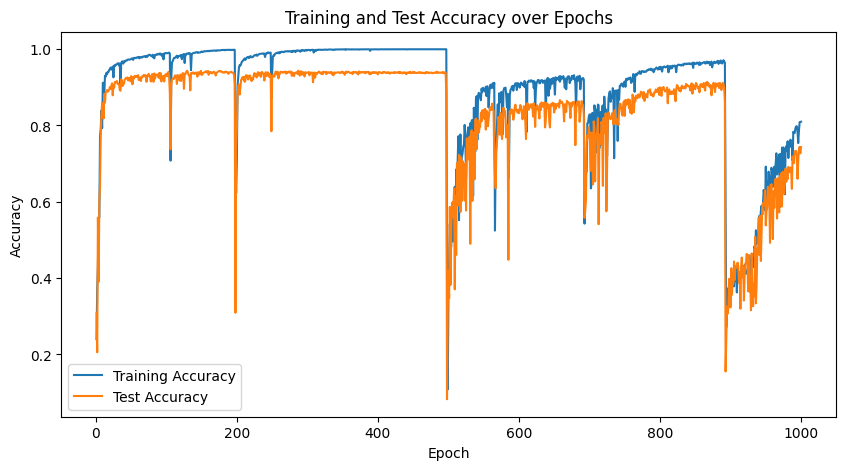

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs + 1), epoch_loss, label="Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cross Entropy Loss over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs + 1), training_accuracy, label="Training Accuracy")
plt.plot(np.arange(1, epochs + 1), test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.show()